In [6]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-xjwhbm__
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-xjwhbm__
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=1c5becdb63f6eaa339b933288acb257ed05c6a8aff913ef7aee2bafbac506538
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0_9c3bv/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [13]:
from google.colab import drive

In [14]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [17]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [18]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [19]:
checkpoint_path = "/content/drive/MyDrive/checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=20)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [64]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_and_preprocess_image(image_path, img_size=(256, 256)):
    img = load_img(image_path, target_size=img_size)
    img = img_to_array(img)  # Convert to array
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

input_image_path = '/content/drive/MyDrive/train5000/sketches/4000_sketch.png'
input_image = load_and_preprocess_image(input_image_path)


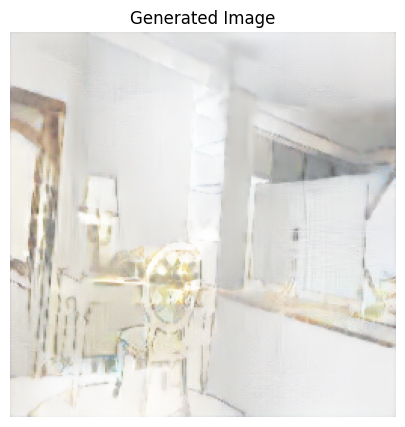

In [65]:
# Generate the image
fake_y = generator_g(input_image, training=False)  # Set training to False to run in inference mode

# Postprocess to display the image
output_image = (fake_y.numpy()[0] * 127.5 + 127.5).astype(np.uint8)  # Convert back to [0, 255]

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(output_image)
plt.title('Generated Image')
plt.axis('off')
plt.show()


In [66]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
def feature_fusion_network(input_shape):
    input_layer = Input(shape=input_shape)
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    output = Conv2D(3, (1, 1), padding='same', activation='sigmoid')(conv3)
    model = Model(inputs=input_layer, outputs=output)
    return model

def load_model_with_weights(model_path, input_shape):
    model = feature_fusion_network(input_shape)
    model.load_weights(model_path)
    return model

# Example usage
input_shape = (256, 256, 3)  # Adjust based on your model training
weights_path = '/content/drive/MyDrive/ffnweights/weights_epoch_01.h5'  # Adjust the filename as needed
ffn_model = load_model_with_weights(weights_path, input_shape)


In [67]:
def prepare_single_image(image_path, target_size=(256, 256)):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image /= 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension for model prediction
    return image


1/1 [==============================] - 0s 198ms/step


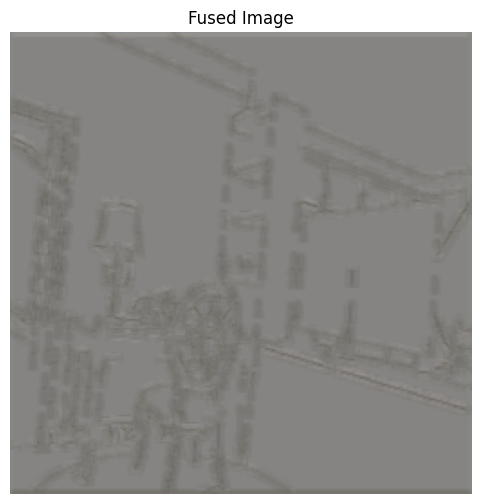

In [69]:
def generate_fused_images(model, input_images):
    fused_images = model.predict(input_images)
    return fused_images

# For a single image
input_image_path = '/content/drive/MyDrive/train5000/sketches/4000_sketch.png'
input_image = prepare_single_image(input_image_path)
fused_image = generate_fused_images(ffn_model, input_image)

# Convert the fused image for visualization
fused_image = np.clip(fused_image.squeeze(), 0, 1)  # Remove batch dimension and clip values

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(fused_image)
plt.title('Fused Image')
plt.axis('off')
plt.show()


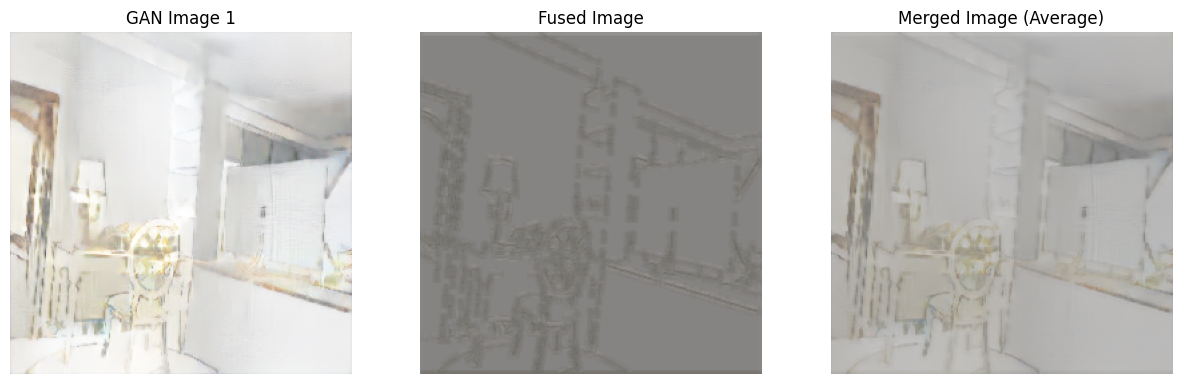

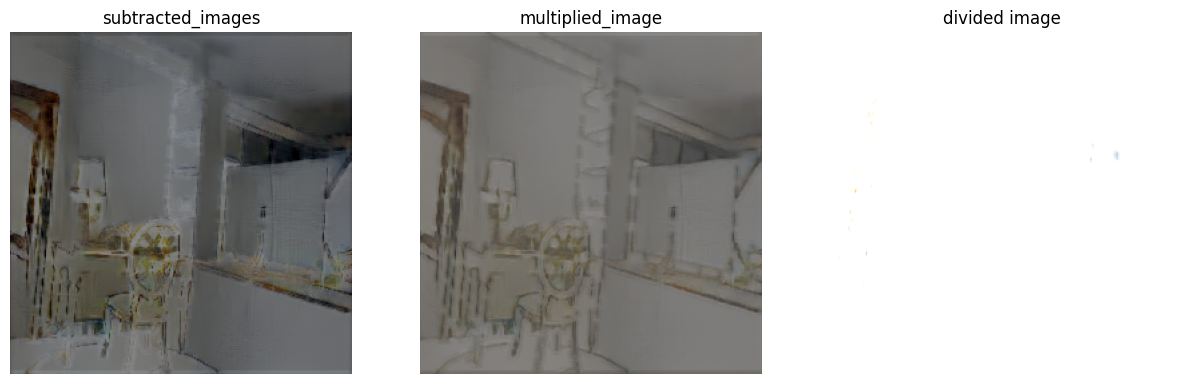

In [76]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os



def merge_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 + image2) / 2.0
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1


def subtract_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 - image2)
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1

def multiply_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    merged = (image1 * image2)%255
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1

def divide_images(image1, image2):
    """Merge two images by averaging their pixel values, ensuring they are floats."""
    if image1.dtype != np.float32:
        image1 = image1.astype(np.float32)
    if image2.dtype != np.float32:
        image2 = image2.astype(np.float32)
    image2 = np.where(image2 == 0, 1e-10, image2)
    merged = (image1 / image2)
    return np.clip(merged, 0, 1)  # Clip values to stay between 0 and 1

def visualize_images(images, titles, figsize=(15, 5)):
    """Display a list of images with titles."""
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    plt.show()









generator_image = output_image
fused_image = fused_image
generator_image = generator_image / 255.0 if np.max(generator_image) > 1 else generator_image
fused_image = fused_image / 255.0 if np.max(fused_image) > 1 else fused_image

merged_image=merge_images( generator_image, fused_image)
merged_image = np.clip(merged_image.squeeze(), 0, 1)

subtracted_image=subtract_images( generator_image, fused_image)
subtracted_image = np.clip(subtracted_image.squeeze(), 0, 1)

multiplied_image=multiply_images( generator_image, fused_image)
multiplied_image = np.clip(multiplied_image.squeeze(), 0, 1)

divided_image=divide_images( generator_image, fused_image)
divided_image = np.clip(divided_image.squeeze(), 0, 1)

visualize_images(
    [generator_image, fused_image, merged_image],
    ['GAN Image 1', 'Fused Image', 'Merged Image (Average)','subtracted_images','multiplied_image','divided image']
)
visualize_images(
    [subtracted_image,
     multiplied_image,divided_image],
    ['subtracted_images','multiplied_image','divided image']
)